Задание 1

Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

Архитектура свёрточной нейронной сети (СНС) RetinaNet состоит из 4 частей

a) Backbone – основная (базовая) сеть, служащая для извлечения признаков из поступающего на вход изображения. Данная часть сети является вариативной и в её основу могут входить классификационные нейросети, такие как ResNet, VGG, EfficientNet и другие;

b) Feature Pyramid Net (FPN) – свёрточная нейронная сеть, построенная в виде пирамиды, служащая для объединения достоинств карт признаков нижних и верхних уровней сети, первые имеют высокое разрешение, но низкую семантическую, обобщающую способность; вторые — наоборот;

c) Classification Subnet – подсеть, извлекающая из FPN информацию о классах объектов, решая задачу классификации;

d) Regression Subnet – подсеть, извлекающая из FPN информацию о координатах объектов на изображении, решая задачу регрессии.

Третей частью архитектуры RetinaNet являются две подсети: классификационная и регрессионная . Каждая из этих подсетей образует на выходе ответ о классе объекта и его расположении на изображении. 


Разница в принципах работы рассматриваемых блоков (подсетей) не отличается до последнего слоя. Каждый из них состоит из 4 слоёв свёрточных сетей. В слое формируются 256 карт признаков. На пятом слое количество карт признаков изменяется: регрессионная подсеть имеет 4*A карт признаков, классификационная – K*A карт признаков, где A – количество якорных рамок, K – количество классов объектов. 

В последнем, шестом, слое каждая карта признаков преобразуется в набор векторов. Регрессионная модель на выходе имеет для каждой якорной рамки вектор из 4 значений, указывающих смещение целевой рамки  относительно якорной. Классификационная модель имеет на выходе для каждой якорной рамки one-hot вектор длиной K, в котором индекс со значением 1 соответствует номеру класса, который нейросеть присвоила объекту.

Во время обучения каждой целевой рамке подбираются в соответствие якорные рамки. Если их показатель IoU имеет значение от 0.5, то якорная рамка назначается целевой, если значение меньше 0.4, то она считается фоном, в других случаях якорная рамка будет проигнорирована для обучения. 
Классификационная сеть обучается относительно выполненного назначения (класс объекта или фон), регрессионная сеть обучается относительно координат якорной рамки (ошибка вычисляется относительно якорной, но не целевой рамки).

Потери RetinaNet являются составными, их составляют два значения: ошибка регрессии, или локализации (Lloc), и ошибка классификации (Lcls). 

RetinaNet, детекторе однокадровых объектов, который быстрее по сравнению с другими двухступенчатыми детекторами, а также решает проблему, которая характерна для всех детекторов одиночного выстрела - детекторы одиночного выстрела не так точны, как двухступенчатые детекторы объектов.

Обучение RetinaNet:Еще одним важным аспектом является инициализация вероятностей модели для переднего класса перед началом обучения.Всем положительным привязкам присваивается априорная вероятность 0,01таким образом, они вносят больший вклад в потерю и обеспечивают, чтобы большое количество отрицательных примеров не мешало обучению на начальном этапе.


Задание 2

In [2]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
# Install TensorFlow
import cv2 as cv
import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [87]:
root_path = '/gdrive/MyDrive/nseti/' #change dir to your project folder 

## **Формирование и обработка результатов детектирования**


Запишем основные функции из примера TensorFlow (https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb) и адаптируем их для своих целей

In [113]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=50, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Формируем тензор

In [89]:
def load_img(path):
  # path - маршрут и имя файла для обработки

  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  # вернет картинку как тензор
  return img

Возвращаем рамки для объектов

In [114]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=50, min_score=0.1):
  """
  Overlay labeled boxes on an image with formatted scores and label names.
  image - картинка, 
  boxes - рамки, 
  class_names - имена классов, 
  scores - оценка качества классификации для отбора рамок

  """
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [115]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=50, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

Загрузка детектора

In [92]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Выполняем детектор

In [116]:

def run_detector(detector, path):
  '''
  1)вызывает детектор с картинкой
  2) выводит результат на картинке

  detector - объект детектор, 
  path - маршрут и имя файла для обработки
  '''
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  #max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции 
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=10)

  display_image(image_with_boxes)
  return result

Чтение имен кадров 

In [118]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]


array('/gdrive/MyDrive/nseti/815_ob_005.jpg', dtype='<U36')

In [119]:
List_name[3]

array('/gdrive/MyDrive/nseti/902398483.jpg', dtype='<U35')

Проверяем детектор

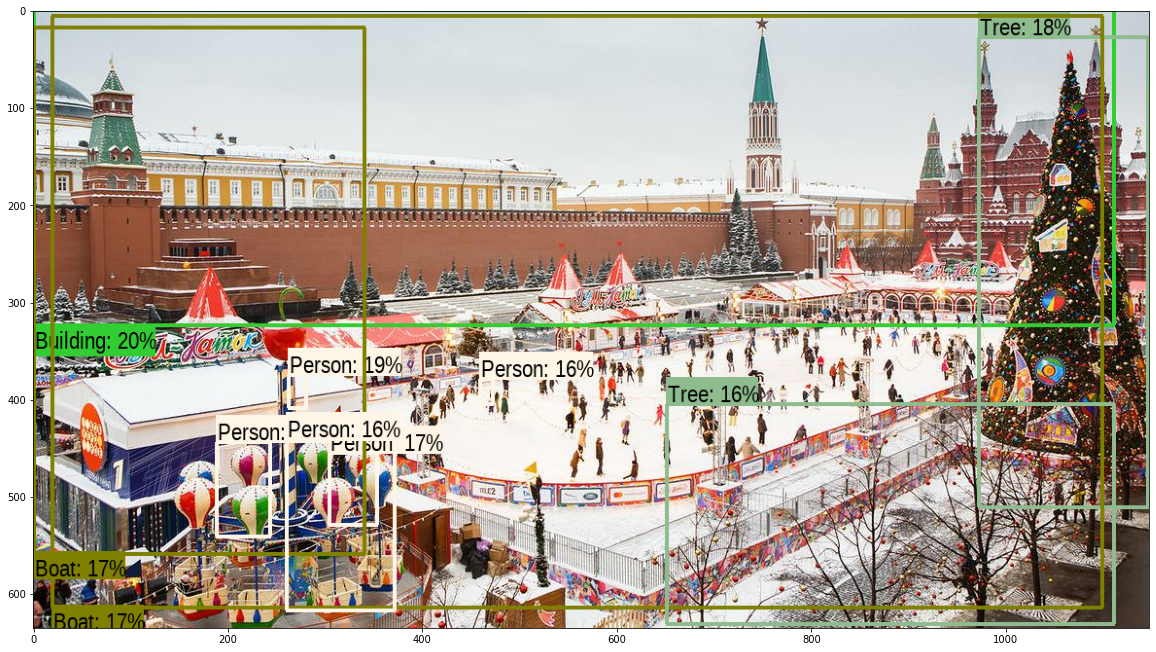

In [102]:
#100 объекта
result = run_detector(detector, List_name[1])

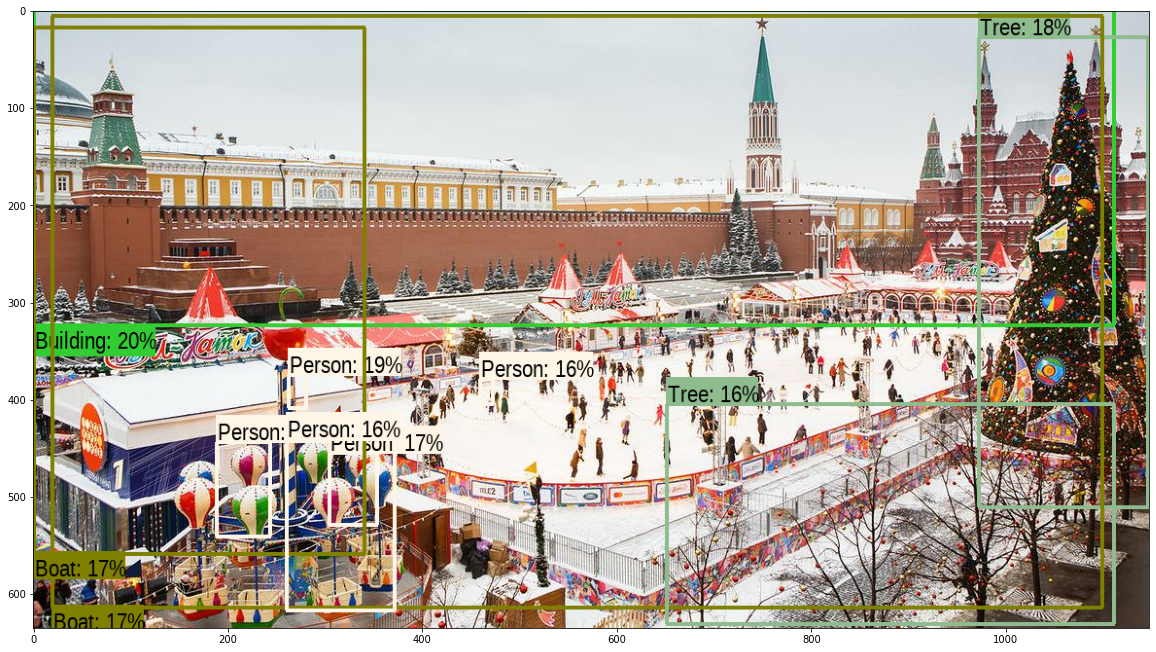

In [108]:
#5 объектов
result = run_detector(detector, List_name[1])

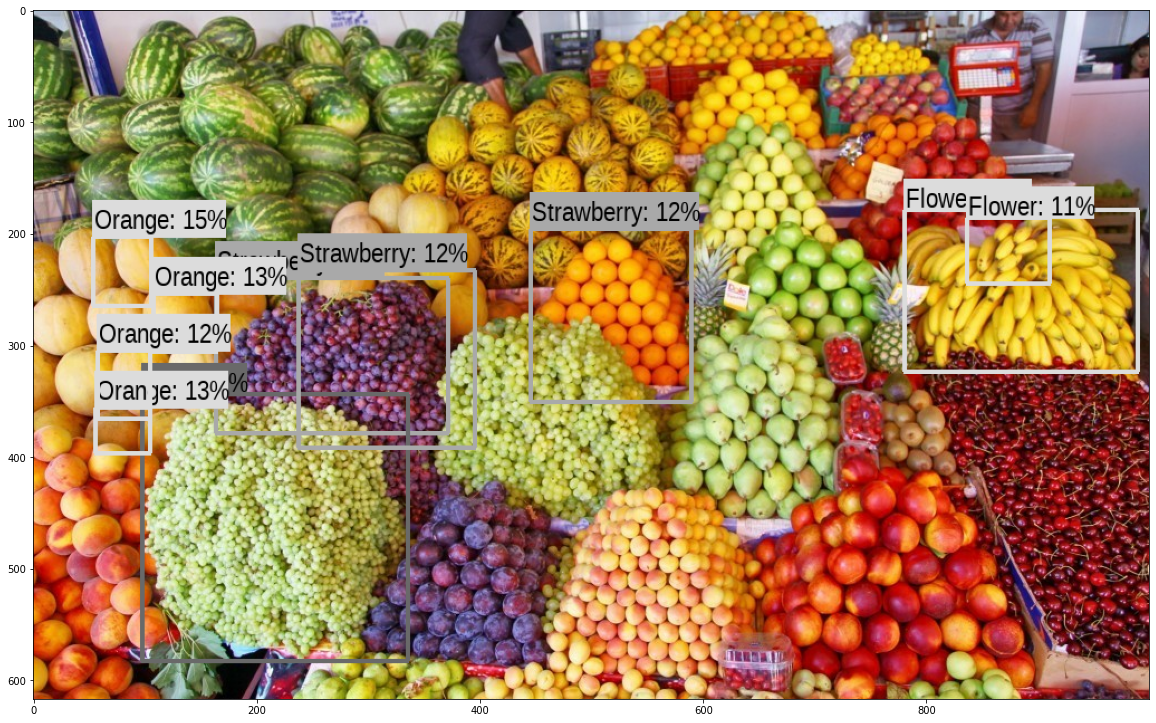

In [112]:
#5 объектов
result = run_detector(detector, List_name[2])

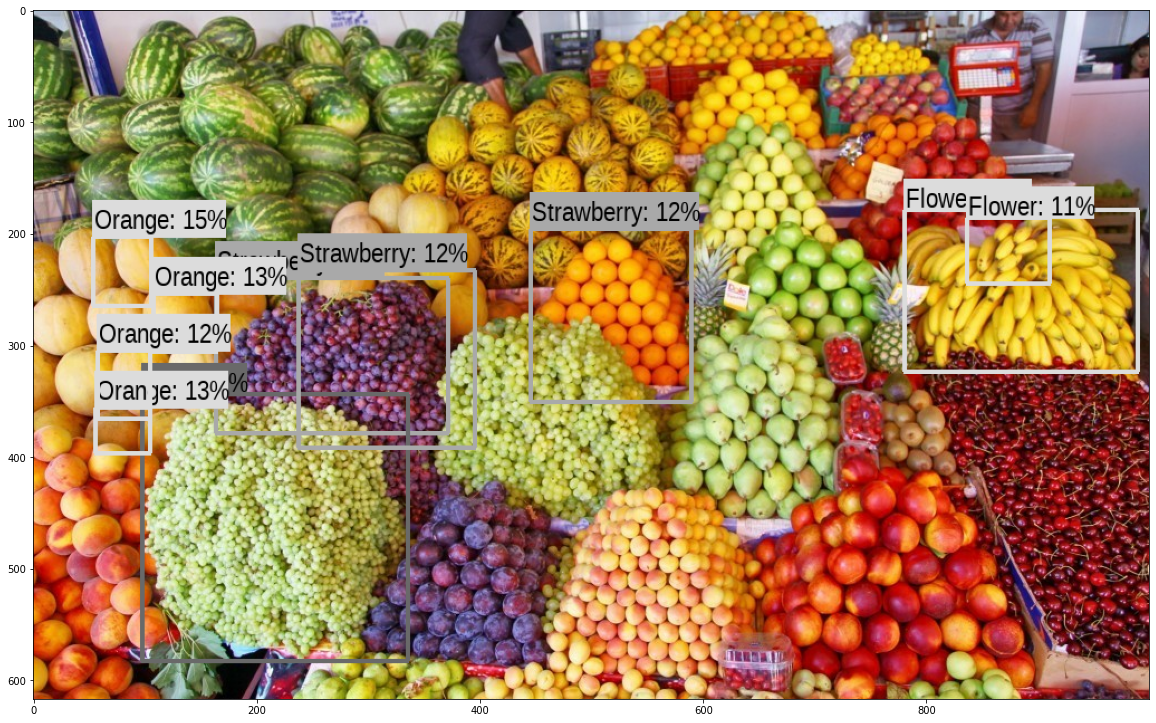

In [117]:
#50 объектов
result = run_detector(detector, List_name[2])

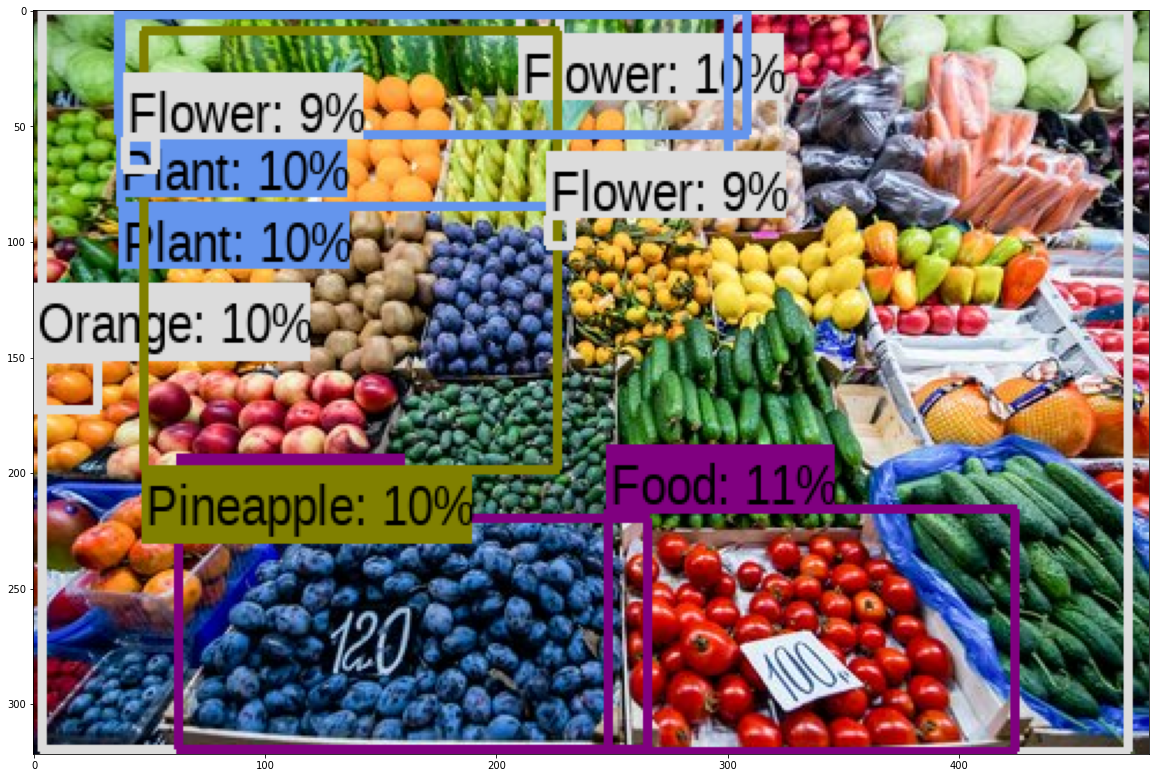

In [120]:
#50 объектов
result = run_detector(detector, List_name[3])

При смене количества объектов разницы я не увидела: 
возможно надо взять картинки с другим качеством и другими объектами